In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [14]:
print("📥 Loading cleaned dataset...")
df = pd.read_csv('data/merged.csv')
print(f"✅ Dataset loaded successfully! Shape: {df.shape}\n")


📥 Loading cleaned dataset...
✅ Dataset loaded successfully! Shape: (200, 32)



### Define target and feature columns

In [15]:
# Define target and features
target = 'Is_Delayed'

drop_cols = [
    'Order_Id', 'Order_Date', 'Origin', 'Destination', 
    'Delivery_Status', 'Delay_Days', 'Actual_Delivery_Days', 
    'Rating_Category', 'Feedback_Text', 'Feedback_Date', 
    'Issue_Category', 'Special_Handling', 'Customer_Rating'
]

X = df.drop(columns=drop_cols + [target], errors='ignore')
y = df[target]


print("🎯 Target variable:", target)
print("🔍 Feature columns used:", list(X.columns))
print()


🎯 Target variable: Is_Delayed
🔍 Feature columns used: ['Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_Inr', 'Carrier', 'Promised_Delivery_Days', 'Quality_Issue', 'Delivery_Cost_Inr', 'Rating', 'Would_Recommend', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead', 'Total_Cost']



### Check class balance

⚖️ Checking class balance:
Is_Delayed
0    130
1     70
Name: count, dtype: int64


C:\Users\Shivam\AppData\Local\Temp\ipykernel_15364\753352675.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


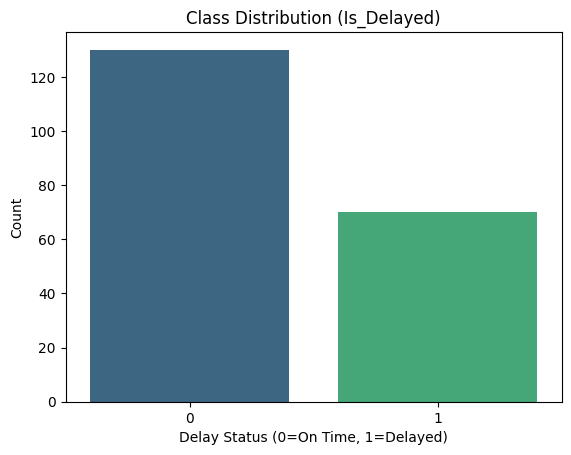

💡 Delay ratio: 0.35
⚠️ Dataset is slightly imbalanced. Will handle using scale_pos_weight in XGBoost.



In [16]:
print("⚖️ Checking class balance:")
class_counts = y.value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution (Is_Delayed)")
plt.xlabel("Delay Status (0=On Time, 1=Delayed)")
plt.ylabel("Count")
plt.savefig("data/class_balance.png")
plt.show()

delay_ratio = class_counts[1] / class_counts.sum()
print(f"💡 Delay ratio: {delay_ratio:.2f}")
if delay_ratio < 0.4 or delay_ratio > 0.6:
    print("⚠️ Dataset is slightly imbalanced. Will handle using scale_pos_weight in XGBoost.\n")
else:
    print("✅ Dataset is fairly balanced.\n")


### Encode categorical columns

In [17]:
cat_cols = X.select_dtypes(include=['object']).columns
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

print(f"✅ Encoded {len(cat_cols)} categorical columns.\n")


✅ Encoded 6 categorical columns.



### Split dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"🧩 Train size: {X_train.shape}, Test size: {X_test.shape}\n")


🧩 Train size: (160, 18), Test size: (40, 18)



### Train XGBoost model

In [19]:
print("🚀 Training XGBoost model...")
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(class_counts[0]/class_counts[1] if delay_ratio < 0.4 else 1),
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print("✅ Model training complete!\n")


🚀 Training XGBoost model...
✅ Model training complete!



### Evaluate model

📈 Model Evaluation Results:
Accuracy: 0.875
F1 Score: 0.828
ROC-AUC: 0.953

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.80      0.86      0.83        14

    accuracy                           0.88        40
   macro avg       0.86      0.87      0.86        40
weighted avg       0.88      0.88      0.88        40



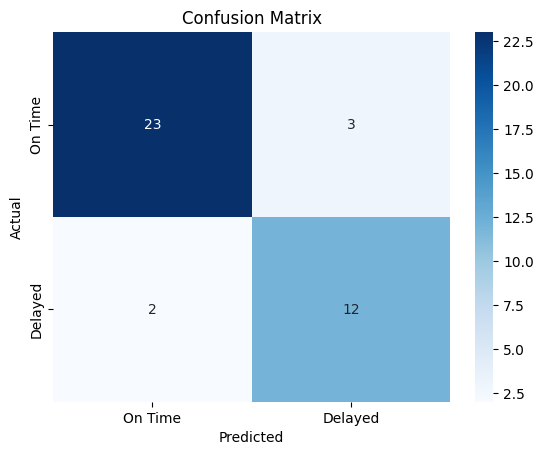

In [21]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("📈 Model Evaluation Results:")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("data/confusion_matrix.png")
plt.show()

### Feature Importance

C:\Users\Shivam\AppData\Local\Temp\ipykernel_15364\3243319153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X.columns[indices], x=importances[indices], palette='mako')


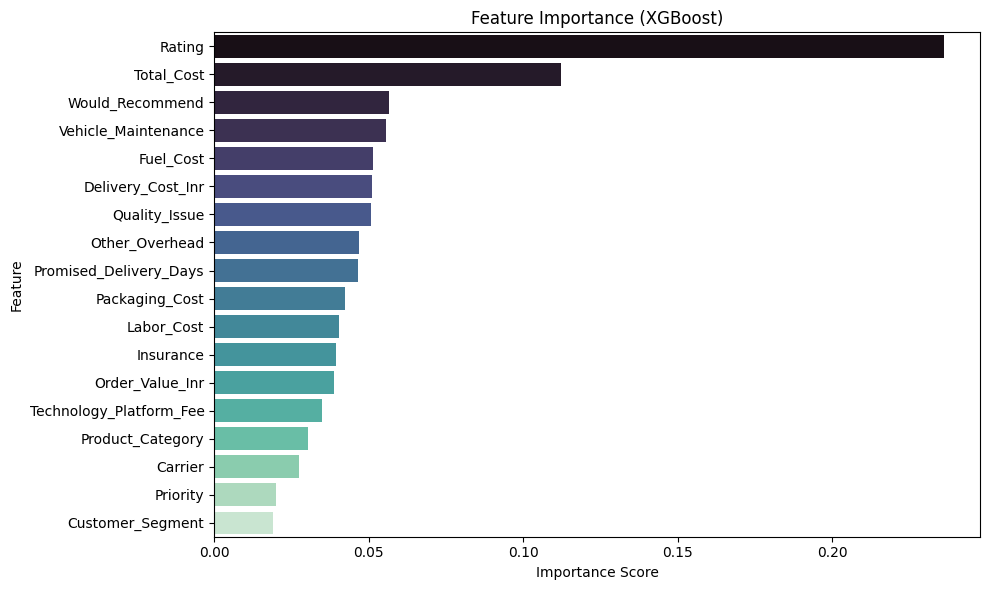

💡 Top important features:
Rating: 0.236
Total_Cost: 0.112
Would_Recommend: 0.057
Vehicle_Maintenance: 0.055
Fuel_Cost: 0.052


In [22]:
plt.figure(figsize=(10,6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(y=X.columns[indices], x=importances[indices], palette='mako')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("data/feature_importance.png")
plt.show()

print("💡 Top important features:")
for feat, val in zip(X.columns[indices][:5], importances[indices][:5]):
    print(f"{feat}: {val:.3f}")



### Save model and encoders


In [23]:

joblib.dump(model, "delay_predictor.pkl")
joblib.dump(encoders, "encoders.pkl")

print("\n💾 Model and encoders saved successfully!")
print("✅ Model training pipeline completed.")


💾 Model and encoders saved successfully!
✅ Model training pipeline completed.
